# Gaia Astrometry

In [26]:
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("xtick", labelsize=27)
matplotlib.rc("ytick", labelsize=27)
matplotlib.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
matplotlib.rc("text", usetex=True)

xo.utils.docs_setup()
print(f"exoplanet.__version__ = '{xo.__version__}'")



exoplanet.__version__ = '0.5.3'


In this case study we’ll walk through a simulating and modeling Gaia DR4 astrometry with exoplanet. This example is done using all simulated data, based on the expected 1$\sigma$ measurement error per observation of epoch astrometry with Gaia DR4 and the Nancy Grace Roman Space Telescope. 

Gaia will release 50-100 (avg = 69) individual epoch astrometry observations for many stars in data release 4. These observations will have a 1$\sigma$ measurement error of approximately 60 $\mu$as (micro-arcseconds). You can read more about Gaia on their website: https://sci.esa.int/web/gaia or in the many papers written about Gaia and its first 3 data releases. # of obs from Perryman+2014 Table 1: https://arxiv.org/pdf/1411.1173.

In what follows, we model in right ascension and declination space (rather than the standard position angle and seperation used in astrometry modeling). We made this decision as position angle doesn't have an independent uncertainty since it depends on the amplitude of the separation, and so we thought it would be a better modeling choice to simulate and model the data in right ascension and declination space.

## (Simulated) Data


First, we need to simulate our dataset. 


### Let's define 2 helpful functions in order to simulate our data....

In [14]:
def create_orbit(n_planets, orbit_params):
    
    '''
    inputs:
    - n_planets = number of planets
    - orbit_params = orbital parameters for each planet arranged as a list of lists:
        - period = period in days
        - ecc = eccentricity 
        - t_periastron = The epoch of a reference periastron passage in days.
        - omega = argument of periapsis in radans
        - Omega = longitude of ascending node  
        - incl = inclination in radians
        - m_planet = mass of planet in Earth masses 
    '''
    

        
    period = []
    ecc = []
    Tper = [] 
    omega = [] 
    Omega = []  
    incl = []
    m_planet = []
    for ii in range(0, n_planets):
        print(orbit_params)
        print(orbit_params[ii])
        period.append(orbit_params[ii][0])
        ecc.append(orbit_params[ii][1])
        Tper.append(orbit_params[ii][2])
        omega.append(orbit_params[ii][3])
        Omega.append(orbit_params[ii][4])
        incl.append(orbit_params[ii][5])
        m_planet.append(orbit_params[ii][6])

    orbit = xo.orbits.KeplerianOrbit(
        period = period,
        ecc = ecc, 
        t_periastron = Tper, 
        omega = omega, 
        Omega = Omega,  
        incl = incl,
        m_planet = m_planet)   
    
    
    return orbit

In [21]:
np.random.seed(979) 

def simulate_data(
    n_planets, 
    sigma_ra,
    sigma_dec,
    plx,
    orbit_params,
    times_observed_astrometry = None,
    t_dur_astrometry = None, 
    n_obs_astrometry = None 
    ):

    '''
    inputs:
    - orbit = keplerian orbit generated by exoplanet code
    - n_planets = number of planets
    - sigma_theta = standard deviation for position angle simulated gaussian noise in as
    - sigma_rho = standard deviation for seperation simulated gaussian noise in as
    - plx = parallax of system
    - orbit_params = orbital parameters for each planet arranged as a list of lists of shape (7 x n_planets):
        - period = period in days
        - ecc = eccentricity 
        - t_periastron = The epoch of a reference periastron passage in days.
        - omega = argument of periapsis in radans
        - Omega = longitude of ascending node  
        - incl = inclination in radians
        - m_planet = mass of planet in Earth masses 
    - times_observed_astrometry = (default=None) the observed times for astrometry observations
    - t_dur_astrometry = (default=None) duration of astrometry observations (only if we don't have a set times of observed observations)
    - n_obs_astrometry = (default=None) number of astrometry observations (only if we don't have a set times of observed observations)
    
        
    '''
    
    if n_planets == 1:
        orbit_params = [orbit_params]
        
                


    #if times_observed_astrometry  != None then just define times_astrometry and linspace between min and max
    if times_observed_astrometry.all()  != None:
        times_astrometry = np.linspace(np.min(times_observed_astrometry), np.max(times_observed_astrometry), 10000)
    
    #define start_time_astrometry, which will be used to determine the times to simulate 
    #if times_observed_astrometry aren't defined    
    else:
        start_time_astrometry = np.inf
        for ii in range(0, n_planets):
            if orbit_params[ii][2] < start_time_astrometry:
                start_time_astrometry = orbit_params[ii][2]    


        #define astrometry observation time
        #100000 is arbitrary large number finely spaced enough to show details in curve
        times_astrometry = np.linspace(start_time_astrometry, start_time_astrometry+t_dur_astrometry, 10000) 
        times_observed_astrometry = np.linspace(start_time_astrometry, start_time_astrometry+t_dur_astrometry, n_obs_astrometry)


        
    orbit = create_orbit(n_planets, orbit_params)


    # determine and print the star position at desired times
    pos = theano.function([], orbit.get_star_position(times_astrometry, plx))()


    #pos = tt.sum(pos, axis=-1)

    x,y,z = pos


    # calculate rho and theta
    rho = tt.squeeze(tt.sqrt(x ** 2 + y ** 2))  # arcsec
    theta = tt.squeeze(tt.arctan2(y, x))  # radians between [-pi, pi]
    
    rho, theta = rho.eval(), theta.eval()
    
    #rho, theta = theano.function([], get_star_relative_angles(times_astrometry, plx))()


    rho_orbit = rho
    
    if n_planets > 1:
        rho_orbit_sum = np.sum(rho_orbit, axis = 1)
    else:
        rho_orbit_sum = rho_orbit

    theta_orbit = theta
    
    if n_planets > 1:
        theta_orbit_sum = np.sum(theta_orbit, axis = 1)
    else:
        theta_orbit_sum = theta_orbit
        
        
    # when summing over theta, position angle, we have to careful because position
    # angle has the range -pi to pi. So for only summing 2 thetas, we can subtract 
    # 2pi whenever theta_sum > pi and add 2pi whenever theta_sum < -pi to get back
    # in the correct range. Be careful though if modeling more than 2 planets, this
    # doesn't completely solve the problem!
    theta_orbit_sum[theta_orbit_sum >  np.pi] -= 2*np.pi
    theta_orbit_sum[theta_orbit_sum < -np.pi] += 2*np.pi


    # determine and print the star position at desired times
    pos_observed = theano.function([], orbit.get_star_position(times_observed_astrometry, plx))()


    #pos = tt.sum(pos, axis=-1)

    x_obs,y_obs,z_obs = pos_observed


    # calculate rho and theta
    rho_observed = tt.squeeze(tt.sqrt(x_obs ** 2 + y_obs ** 2))  # arcsec
    theta_observed = tt.squeeze(tt.arctan2(y_obs, x_obs))  # radians between [-pi, pi]
    
    rho_observed, theta_observed = rho_observed.eval(), theta_observed.eval()


    
    if n_planets > 1:
        rho_observed_sum = np.sum(rho_observed, axis = 1)
    else:
        rho_observed_sum = rho_observed

    
    if n_planets > 1:
        theta_observed_sum = np.sum(theta_observed, axis = 1)
    else:
        theta_observed_sum = theta_observed
        
    
    #######
    #######
    #######

    # convert rho and theta into ra and dec
    ra_orbit = rho_orbit * np.sin(theta_orbit) # +ra is east
    dec_orbit = rho_orbit * np.cos(theta_orbit)  # +dec is north

    if n_planets > 1:
        ra_orbit_sum = np.sum(ra_orbit, axis = 1)
    else:
        ra_orbit_sum = ra_orbit

    
    if n_planets > 1:
        dec_orbit_sum = np.sum(dec_orbit, axis = 1)
    else:
        dec_orbit_sum = dec_orbit

    ra_observed = rho_observed * np.sin(theta_observed) # +ra is east
    dec_observed = rho_observed * np.cos(theta_observed)  # +dec is north




    
    #----------- 
    #----------- 
    #----------- simulate data
    #----------- 
    #----------- 


    #-----------
    #-----------


    if n_planets > 1:
        ra_sim = ra_observed 
        ra_sim_sum = np.sum(ra_sim, axis = 1) + np.random.normal(0, sigma_ra, len(ra_observed))
    
    else:
        ra_sim = ra_observed + np.random.normal(0, sigma_ra, len(ra_observed))
        ra_sim_sum = ra_sim
      
    
    
    if n_planets > 1:
        dec_sim = dec_observed 
        dec_sim_sum = np.sum(dec_sim, axis = 1) + np.random.normal(0, sigma_dec, len(dec_observed))
        
    else:
        dec_sim = dec_observed + np.random.normal(0, sigma_dec, len(dec_observed))
        dec_sim_sum = dec_sim

    
    times = [times_astrometry, times_observed_astrometry]
    ra_results = [ra_orbit, ra_orbit_sum, ra_sim, ra_sim_sum]
    dec_results = [dec_orbit, dec_orbit_sum, dec_sim, dec_sim_sum]
   
    
    return [times, ra_results, dec_results]


### Let's now define our orbital parameters:

We will be simulating (and then modeling) the signal from Jupiter orbiting around the Sun, observed 10 parsecs (parallax = 0.1 as) away, with an inclination of 45 degrees. In total, our orbital parameters are:

|planet | period (days) | ecc | Tper | omega (rad) | Omega (rad) | inclination (rad) | mass (solar masses) |
| --- | --- | --- | --- | --- | --- | --- | --- |
|Jupiter | 4327.0 | 0.0484 | 500.0 | -1.4957471689591395 | 1.7523105690023069 | $\pi$/4 + 0.022759 | 0.000955 |

In [28]:
import numpy as np

parallax = 0.1 #as 
n_planets=1
planet_params = [1000,0.0484,500.0,-1.4957471689591395,1.7523105690023069,np.pi/4+0.022759,0.000955]

### And now we define our observing parameters:

Gaia Astrometry: To be conservative, we will assume we have 69 Gaia observations spread out evenly over the 5.5 years since the initial launch in 2013. White noise errors = 1$\sigma$ measurement error = 60 $\mu$as.


In [29]:
from aesara_theano_fallback import aesara as theano
import theano.tensor as tt


#add gaia observing times
import numpy as np

t_0 = 0
t_gaia = 5.5 * 365
n_obs_gaia = 69

times_observed_astrometry_gaia = np.linspace(t_0, t_gaia, n_obs_gaia)


sigma_ra_gaia = 6e-5 #60 micro-as
sigma_dec_gaia = 6e-5 #60 micro-as



times, ra_results, dec_results = simulate_data(
    n_planets, 
    sigma_ra_gaia,
    sigma_dec_gaia,
    parallax,
    planet_params,
    times_observed_astrometry = times_observed_astrometry_gaia
    )


[[times_astrometry, times_observed_astrometry],
[ra_orbit, ra_orbit_sum, ra_sim, ra_sim_sum],
[dec_orbit, dec_orbit_sum, dec_sim, dec_sim_sum]]  = times, ra_results, dec_results

ra_gaia_err = np.full(np.shape(ra_sim_sum), sigma_ra_gaia)
dec_gaia_err = np.full(np.shape(dec_sim_sum), sigma_dec_gaia)





[[1000, 0.0484, 500.0, -1.4957471689591395, 1.7523105690023069, 0.8081571633974483, 0.000955]]
[1000, 0.0484, 500.0, -1.4957471689591395, 1.7523105690023069, 0.8081571633974483, 0.000955]


## Let's write some functions to plot our simulated data:

In [30]:
def plot_astrometry_signal(
    n_planets, 
    ra_orbit, 
    ra_orbit_sum, 
    ra_sim, 
    ra_sim_sum, 
    dec_orbit, 
    dec_orbit_sum, 
    dec_sim, 
    dec_sim_sum,
    times_astrometry,
    times_observed_astrometry):
    
    

    fig, ax = plt.subplots(2, 1, figsize = [13,10], sharex='col', sharey='row')
    fig.suptitle("Astrometric Signal", fontsize = 45)
    ax2 = ax[0]
    ax3 = ax[1]
    


    
    ax2.plot(times_observed_astrometry, ra_sim_sum, 'o', color = 'k', label = 'combined signal')
    for tick in ax3.get_xticklabels():
        tick.set_rotation(30)
    ax2.legend(fontsize = 27, loc = 2)
    
    ax3.plot(times_observed_astrometry, dec_sim_sum, 'o', color = 'k', label = 'combined signal')
    ax2.set_xlabel("time [BJD]", fontsize = 27)
    ax3.legend(fontsize = 27, loc = 2)



    fig.tight_layout()
    fig.show()



    #######
    #######
    #######


    fig, ax = plt.subplots(1, 1, figsize = [10, 10])

    # plot simulated data
    ax.plot(ra_sim_sum, dec_sim_sum, 'o', color = 'k', label = "combined signal")

    ax.set_ylabel(r"$\Delta \delta$ ['']")
    ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
    ax.invert_xaxis()
    ax.plot(0, 0, "k*")
    ax.set_aspect("equal", "datalim")
    ax.set_title("initial orbit")
    ax.legend()
    fig.show()
    
    return None

## And now, let's plot

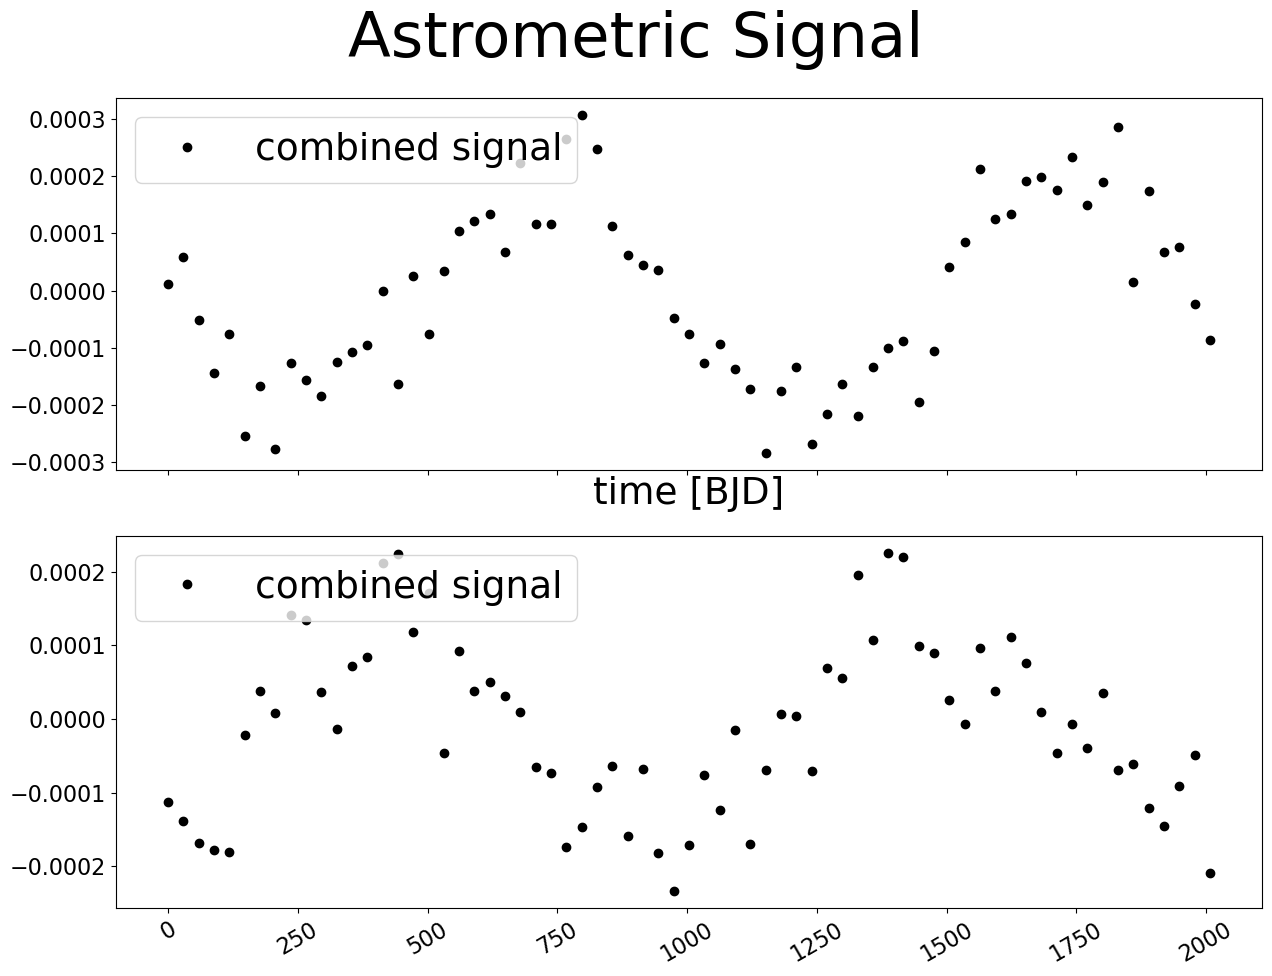

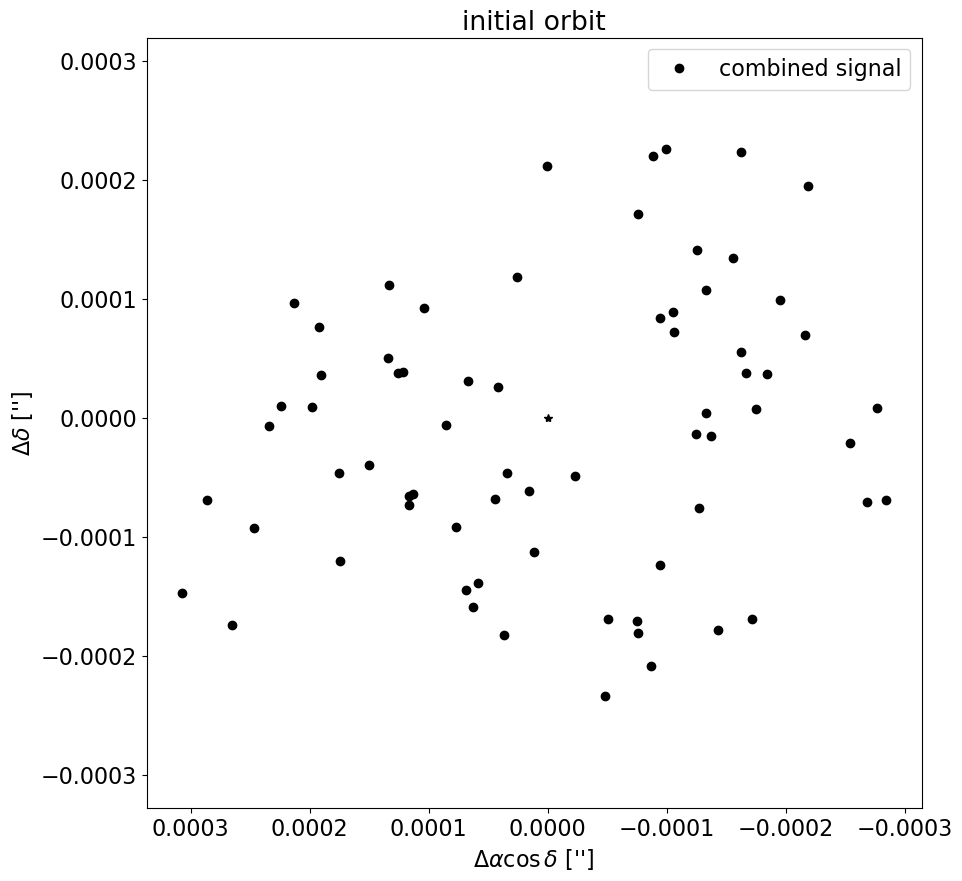

In [31]:
plot_astrometry_signal(
    n_planets, 
    ra_orbit, 
    ra_orbit_sum, 
    ra_sim, 
    ra_sim_sum, 
    dec_orbit, 
    dec_orbit_sum, 
    dec_sim, 
    dec_sim_sum,
    times_astrometry,
    times_observed_astrometry)

## Ok, now we have a simulated dataset -- let's model it!



In [32]:
def minimize_both(rv_map_soln, x_rv, y_rv, y_rv_err, x_astrometry, ra_data, ra_err, dec_data, dec_err, parallax):
    m_sun = 333030 #earth masses
    
    P_RV = np.array(rv_map_soln['P'])
    K_RV = np.array(rv_map_soln['K'])
    tperi_RV = np.array(rv_map_soln['tperi'])
    ecc_RV = np.array(rv_map_soln['ecc'])
    omega_RV = np.array(rv_map_soln['omega'])
    min_masses_RV = xo.estimate_minimum_mass(P_RV, x_rv, y_rv, y_rv_err).value*317.83 #in m_earth
    phase_RV = determine_phase(P_RV, tperi_RV)
    
    
    # make a fine grid that spans the observation window for plotting purposes
    t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
    t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

    # for predicted orbits
    t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)


    print("RV Solutions")
    print("------------")
    print("P: ", P_RV)
    print("K: ", K_RV)
    print("T_peri: ", tperi_RV)
    print("eccentricity: ", ecc_RV)
    print("omega: ", omega_RV)

    print('')
    print("minimizing joint model solutions pre-MCMC")
    print("------------")

    # for predicted orbits
    t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)

    inc_test_vals = np.array(np.radians([5., 25., 45., 65., 85.]))
    model, map_soln, logp = [], [], []
    for inc in inc_test_vals:
        mass_test_vals = min_masses_RV/np.sin(inc)
        print('')
        print("trying inclination = " + str(np.degrees(inc)))
        print("mass test val = " + str(mass_test_vals))
        print("------------")
        
        



        def get_model():
            with pm.Model() as model:


                # Below we will run a version of this model where a measurement of parallax is provided
                # The measurement is in milliarcsec
                m_plx = pm.Bound(pm.Normal, lower=0, upper=200)(
                    "m_plx", mu=parallax*1000, sd=10, testval=parallax*1000
                )
                plx = pm.Deterministic("plx", 1e-3 * m_plx)


                # We expect the period to be around that found from just the RVs,
                # so we'll set a broad prior on logP
                
                logP = pm.Uniform(
                    "logP", lower=0, upper=np.log(2*P_RV), testval=np.log(P_RV), shape=2
                )
                P = pm.Deterministic("P", tt.exp(logP))
                
                # Eccentricity & argument of periasteron
                ecs = pmx.UnitDisk("ecs", shape=(2, 2), 
                                   testval=np.array([np.sqrt(ecc_RV)*np.cos(omega_RV), 
                                                     np.sqrt(ecc_RV)*np.sin(omega_RV)]))
                ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
                omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

                xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

                
                

                # Omegas are co-dependent, so sample them with variables Omega_plus
                # and Omegas_minus. Omega_plus is (Omega_0 + Omega_1)/2 and 
                # Omega_minus is (Omega_0 - Omega_1)/2
                
                Omega_plus = pmx.Angle("Omega_plus", shape=1)
                Omega_minus = pmx.Angle("Omega_minus", shape=1)
                
                
                Omega = tt.concatenate( [(Omega_plus + Omega_minus),
                                         (Omega_plus - Omega_minus)] )
                

                Omega = pm.Deterministic("Omega", Omega) 
                Omega_sum = pm.Deterministic("Omega_sum", ((Omega_plus)*2)% np.pi)
                Omega_diff = pm.Deterministic("Omega_diff", ((Omega_minus)*2)% np.pi)
                


            
                # For these orbits, it can also be better to fit for a phase angle
                # (relative to a reference time) instead of the time of periasteron
                # passage directly
                phase = pmx.Angle("phase", testval=phase_RV, shape=2)
                tperi = pm.Deterministic("tperi", P * phase / (2 * np.pi))
                

                
                # uniform prior on sqrtm_sini and sqrtm_cosi (upper 100* testval to stop planet flipping)
                log_m = pm.Uniform("log_m", lower=-1, upper=np.log(100*mass_test_vals), testval=np.log(mass_test_vals), shape=2)
                m_planet = pm.Deterministic("m_planet", tt.exp(log_m))
                m_planet_fit = pm.Deterministic("m_planet_fit", m_planet/m_sun)


                cos_incl = pm.Uniform("cos_incl", lower=0, upper=1, testval=np.cos(inc), shape=2)
                incl = pm.Deterministic("incl", tt.arccos(cos_incl))
                


                
                
                # Set up the orbit
                orbit = xo.orbits.KeplerianOrbit(
                    t_periastron=tperi,
                    period=P,
                    incl=incl,
                    ecc=ecc,
                    omega=omega,
                    Omega=Omega,
                    m_planet = m_planet_fit,
                    plx=plx
                )


                
                
                # Add a function for computing the full astrometry model
                def get_astrometry_model(t, name=""):
                    # First the astrometry induced by the planets

                    # determine and print the star position at desired times
                    pos = orbit.get_star_position(t, plx)

                    x,y,z = pos


                    # calculate rho and theta
                    rhos = tt.squeeze(tt.sqrt(x ** 2 + y ** 2))  # arcsec
                    thetas = tt.squeeze(tt.arctan2(y, x))  # radians between [-pi, pi]
                                    
                    
                    #rhos, thetas = get_star_relative_angles(t, plx)
                    
                    
                    dec = pm.Deterministic("dec" + name, rhos * np.cos(thetas)) # X is north
                    ra = pm.Deterministic("ra" + name, rhos * np.sin(thetas)) # Y is east
                    
                    # Sum over planets to get the full model
                    dec_model = pm.Deterministic("dec_model" + name, tt.sum(dec, axis=-1))
                    ra_model = pm.Deterministic("ra_model" + name, tt.sum(ra, axis=-1))
                    

                    
                    return dec_model, ra_model

                
                # Define the astrometry model at the observed times
                dec_model, ra_model = get_astrometry_model(x_astrometry)

                # Also define the model on a fine grid as computed above (for plotting)
                dec_model_fine, ra_model_fine = get_astrometry_model(t_fine, name="_fine")

                


                #dec_tot_err = tt.sqrt(dec_err ** 2 + tt.exp(2 * log_dec_s))
                #ra_tot_err = tt.sqrt(ra_err ** 2 + tt.exp(2 * log_ra_s))
                dec_tot_err = dec_err
                ra_tot_err = ra_err


                # define the likelihood function, e.g., a Gaussian on both ra and dec        
                pm.Normal("dec_obs", mu=dec_model, sd=dec_tot_err, observed=dec_data)
                pm.Normal("ra_obs", mu=ra_model, sd=ra_tot_err, observed=ra_data)


                
                
                # ADD RV MODEL


                # And a function for computing the full RV model
                def get_rv_model(t, name=""):
                    # First the RVs induced by the planets
                    vrad = orbit.get_radial_velocity(t)
                    pm.Deterministic("vrad" + name, vrad)

                    # Sum over planets to get the full model
                    return pm.Deterministic("rv_model" + name, tt.sum(vrad, axis=-1))

                # Define the RVs at the observed times
                rv_model = get_rv_model(x_rv)

                # Also define the model on a fine grid as computed above (for plotting)
                rv_model_pred = get_rv_model(t_rv, name="_pred")

                # Finally add in the observation model. This next line adds a new contribution
                # to the log probability of the PyMC3 model
                rv_err = y_rv_err
                pm.Normal("obs_RV", mu=rv_model, sd=rv_err, observed=y_rv)

                # Optimize to find the initial parameters
                map_soln = model.test_point
                map_soln = pmx.optimize(map_soln, vars=[Omega, phase])
                #map_soln = pmx.optimize(map_soln, vars=[Omega, m_planet, incl, ecs, phase])

                map_soln = pmx.optimize(map_soln)


            return model, map_soln



        a_model, a_map_soln = get_model()
        a_logp = a_model.check_test_point(test_point=a_map_soln).sum(axis = 0)
        print('log likelihood = ' + str(a_logp))

        model.append(a_model)
        map_soln.append(a_map_soln)
        logp.append(a_logp)

    
    best_index = 0
    for index in range(0, len(model)):
        if logp[index] >= logp[best_index]:
            best_index = index

    the_model = model[best_index]
    the_map_soln = map_soln[best_index]
    the_logp = logp[best_index]



    return the_model, the_map_soln, the_logp



def determine_phase(P, t_periastron):
    phase = (2 * np.pi * t_periastron) / P
    return phase



def model_both(model, map_soln, tune_steps, draw_steps):
    print('Joint RV + Astometry Minimization Solutions:')
    print("------------")

    print('m_planet: ' + str(map_soln['m_planet']))
    print('P: ' + str(map_soln['P']))
    print('incl: ' + str(map_soln['incl']))
    print('Omega: ' + str(map_soln['Omega']))
    print('tperi: ' + str(map_soln['tperi']))
    print('ecc: ' + str(map_soln['ecc']))
    print('omega: ' + str(map_soln['omega']))
    print('plx: ' + str(map_soln['plx']))


    with model:
        trace = pmx.sample(
            tune=tune_steps,
            draws=draw_steps,
            start=map_soln,
            cores=2,
            chains=2,
            target_accept=0.99,
            return_inferencedata=True,
        )

    return trace

In [33]:
from astropy.constants import M_sun
from astropy import constants

################
################
#minimize on joint model
joint_model, joint_map_soln, joint_logp = minimize_both(
    rv_map_soln, x_rv, y_rv, y_rv_err, x_astrometry, 
    ra_data, ra_err, dec_data, dec_err, parallax
)




################
################
#run full MCMC
trace = model_both(joint_model, joint_map_soln, 1000, 1000)

NameError: name 'rv_map_soln' is not defined

## Define some plotting functions that will help us check convergence and the covariance of the modelling parameters:

In [ ]:
matplotlib.rc('text', usetex=False)

def make_plots(trace, orbit_params, n_planets):
    m_sun = 333030 #earth masses

    [orbit_params_earth, orbit_params_jup] = orbit_params


    [P_earth, e_earth, Tper_earth, omega_earth, Omega_earth, 
     inclination_earth, m_earth] = orbit_params_earth


    [P_jup, e_jup, Tper_jup, omega_jup, Omega_jup, 
    inclination_jup, m_jup] = orbit_params_jup


    a_true_earth = a_from_Kepler3(P_earth, 1.0+m_earth)
    a_true_jup = a_from_Kepler3(P_jup, 1.0+m_jup)

    #[P1, P2, e1, e2, omega1, omega2, Omega_sum, Omega_minus, incl1, incl2, plx, m1, m2, a1, a2, Tper1, Tper2]
    truths = [P_jup, P_earth, e_jup, e_earth, omega_jup, omega_earth, 
    Omega_earth-Omega_jup, Omega_earth+Omega_jup, inclination_jup, inclination_earth, 
    0.1, m_jup*m_sun, m_earth*m_sun, Tper_jup, Tper_earth]


    #[P1, P2, e1, e2, omega1, omega2, incl1, incl2, Tper1, Tper2, m1, m2, a1, a2]
    truth_chain_plot = [P_jup, P_earth, e_jup, e_earth, omega_jup, omega_earth,
    inclination_jup, inclination_earth, Tper_jup, Tper_earth, m_jup*m_sun, m_earth*m_sun]









    # plot the table summarizing MCMC results
    az.summary(
        trace,
        var_names=["P", "tperi", "omega", "Omega_sum", "Omega_plus", "Omega_minus", 
                   "incl", "ecc", "plx", "m_planet"],
    )


    plt.show()





    # plot the corner plots
    _ = corner.corner(
        trace, var_names=["P", "ecc", "omega", "Omega_sum", "Omega_minus", "incl", 
                          "plx", "m_planet", 'tperi'], quantiles=[0.16, 0.5, 0.84],
                           show_titles=True, title_kwargs={"fontsize": 13}, 
                           truths = truths, truth_color = "#03003a"
    )

    plt.show()









    # plot the chains
    parameters = ["P", "ecc", "omega", "incl", "tperi", "m_planet"]
    for ii in range(0, len(parameters)):
        plot_truth = False
        param = parameters[ii]
        
        true_vals_earth = truth_chain_plot[2*ii]
        true_vals_jup = truth_chain_plot[2*ii+1]
        plot_truth = True
        
        fig, ax = plt.subplots(1,2, figsize = (15,3))
        planet1_chain1 = trace.posterior[param].values[:, :, 0][0]
        planet1_chain2 = trace.posterior[param].values[:, :, 0][1]
        
        planet2_chain1 = trace.posterior[param].values[:, :, 1][0]
        planet2_chain2 = trace.posterior[param].values[:, :, 1][1]
        
        
        nstep = np.arange(1, len(planet1_chain1)+1, 1)
        
        
        ax[0].plot(nstep, planet1_chain1)
        ax[0].plot(nstep, planet1_chain2)
        
        if plot_truth:
            ax[0].axhline(y=true_vals_earth, color = 'r', label = 'truth')
        ax[0].set_title("Jupiter", fontsize = 18)
        ax[0].legend(fontsize = 18)
        
        ax[1].plot(nstep, planet2_chain1)
        ax[1].plot(nstep, planet2_chain2)
        
        if plot_truth:
            ax[1].axhline(y=true_vals_jup, color = 'r', label = 'truth')
        ax[1].set_title("Earth", fontsize = 18)
        ax[1].legend(fontsize = 18)

        fig.suptitle(param, fontsize = 18)
        fig.tight_layout()
        plt.show()




    return "plotting complete"





def a_from_Kepler3(period, M_tot):
    period = period*86400 #days to seconds
    

    M_tot = M_tot*M_sun.value #solar masses to kg
    
    a3 = ( ((constants.G.value)*M_tot) / (4*np.pi**2) ) * (period)**2.
    
    a = a3**(1/3)
    
    
    
    a = a * 6.68459*10**(-12.) # meters to AU
    
    return(a) #in AUs





## Check the convergence diagnostics:

In [ ]:
import arviz as az

az.summary(trace, var_names=[
        "P",
        "ecc",
        "m_planet",
        "Omega",
        "omega",
        "incl"])


Great, the r_hat statistitcs are all 1.0, suggesting that the chains are converged...

 ...we can also check this by eye by looking at the corner plots and the posterior chains!

In [ ]:
import corner

make_plots(trace, planet_params, 2)


## Now, let's plot the MCMC posterior and simulated RV and Astrometry data

In [ ]:
import pandas as pd
#save simulated data as dataframe 
simulated_data_dic = {
    "times_rv_observed": x_rv,
    "rv_observed": y_rv,
    "rv_err_observed": y_rv_err,

    "times_rv_orbit": times_rv,
    "rv_orbit": rv_orbit,
    "rv_orbit_sum": rv_orbit_sum,

    "times_astrometry_observed": x_astrometry,
    "ra_observed": ra_data,
    "dec_observed": dec_data,
    "ra_err_observed": ra_err,
    "dec_err_observed": dec_err,

    "times_astrometry_orbit": times_astrometry,
    "ra_orbit": ra_orbit,
    "ra_orbit_sum": ra_orbit_sum,
    "dec_orbit": dec_orbit,
    "dec_orbit_sum": dec_orbit_sum
    }


simulated_data = pd.DataFrame.from_dict(simulated_data_dic, orient='index')
simulated_data = simulated_data.transpose()
simulated_data = simulated_data.fillna(value=np.nan)



In [ ]:
def remove_nans(array):
    array = array[~pd.isnull(array)]
    
    return array




def import_orbit_data(orbit_row):
    import math
    
    orbit_row = remove_nans(orbit_row)
    orbit_array = []
    for row in orbit_row:
        orbit_array.append([np.array(row[1]), row[0]])

    orbit_array = np.array(orbit_array)
    
    return orbit_array




def make_rv_astrometry_plots(simulated_data, trace, nplanets):
    import matplotlib.pyplot as plt

    
    
    #simulated RV observations
    x_rv = simulated_data['times_rv_observed'].values
    y_rv = simulated_data['rv_observed'].values
    y_rv_err = simulated_data['rv_err_observed'].values
   
    #simulated RV full orbits
    x_rv_orbit = simulated_data['times_rv_orbit'].values
    y_rv_orbit = simulated_data['rv_orbit'].values
    
    #simulated astrometric observations
    x_astrometry = simulated_data['times_astrometry_observed'].values
    y_ra = simulated_data['ra_observed'].values
    y_dec = simulated_data['dec_observed'].values
    y_ra_err = simulated_data['ra_err_observed'].values
    y_dec_err = simulated_data['dec_err_observed'].values
    
    #simulated astrometric full orbits
    x_astrometry_orbit = simulated_data['times_astrometry_orbit'].values
    y_ra_orbit = simulated_data['ra_orbit'].values
    y_dec_orbit = simulated_data['dec_orbit'].values
     
    
    #remove any nans from simulated data (created because of mismatching lengths)
    x_rv = remove_nans(x_rv)
    y_rv = remove_nans(y_rv)
    y_rv_err = remove_nans(y_rv_err)
    x_rv_orbit = remove_nans(x_rv_orbit)
    y_rv_orbit = import_orbit_data(y_rv_orbit)
    x_astrometry = remove_nans(x_astrometry)
    y_ra = remove_nans(y_ra)
    y_dec = remove_nans(y_dec)
    y_ra_err = remove_nans(y_ra_err)
    y_dec_err = remove_nans(y_dec_err)
    x_astrometry_orbit = remove_nans(x_astrometry_orbit)
    y_ra_orbit = import_orbit_data(y_ra_orbit)
    y_dec_orbit = import_orbit_data(y_dec_orbit)
    
    
    
    
    # make a fine grid that spans the observation window for plotting purposes
    t_astrometry = np.linspace(x_astrometry.min() - 5, x_astrometry.max() + 5, 1000)
    t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 1000)

    # for predicted orbits
    t_fine = np.linspace(x_astrometry.min() - 500, x_astrometry.max() + 500, num=1000)
    
    
         
    
    
    # add NaN for plotting purpose on true model
    x_astrometry_orbit = np.insert(x_astrometry_orbit, 10000, float('NaN'))
    y_ra_orbit = np.insert(y_ra_orbit, 10000, float('NaN'), axis=0)
    y_dec_orbit = np.insert(y_dec_orbit, 10000, float('NaN'),axis=0)
            
    
    


    
    
    figsAs = []
    figsRV = []
    for n in range(0, nplanets):
        
        ######
        #make rv plots
    
    
        figRV, ax = plt.subplots(2, 1, figsize = [13, 6], gridspec_kw={'height_ratios': [3, 1]})
        ax0, ax1 = ax[0], ax[1]
        
        # Get the posterior median orbital parameters
        p = np.median(trace.posterior["P"].values[:, :, n])
        t0 = np.median(trace.posterior["tperi"].values[:, :, n])

        # Compute the median of posterior estimate the other planet. Then we can remove
        # this from the data to plot just the planet we care about.
        other = np.median(
            trace.posterior["vrad"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
        )







        # Plot the data
        ax0.errorbar(x_rv, y_rv - other, yerr=y_rv_err, fmt=".", 
                     color = "#00257c", label = "data", alpha = 0.7)


        pred = np.percentile(
            trace.posterior["vrad_pred"].values[:, :, :, n],
            [16, 50, 84],
            axis=(0, 1),
        )
        
        med_rv = []
        for an_x in x_rv:
            med_rv.append(np.interp(an_x, t_rv, pred[1]))



        
        # plot the MCMC model
        ax0.plot(t_rv, pred[1], color="r", label="posterior")
        art = ax0.fill_between(
            t_rv, pred[0], pred[2], color="r", alpha=0.3
        )
        art.set_edgecolor("none")
        
        # plot the true RA model
        ax0.plot(x_rv_orbit, y_rv_orbit.T[n], color = 'k', label = "truth")








        ax0.legend(fontsize=9, loc=1)
        ax0.set_xlabel("phase [days]", fontsize=18)
        ax0.set_ylabel("radial velocity [m/s]", fontsize=18)
        
        ax1.set_ylabel(r"[O-C]", fontsize = 18)
        ax1.set_xlabel("phase [days]", fontsize=18)



        
        
        
        #plot residuals
        ax1.axhline(0.0, color="k")
        ax1.errorbar(
            x_rv, y_rv - other - med_rv,
            yerr=y_rv_err, color = '#00257c', fmt="."
        )
        
        
        figRV.tight_layout()
        figRV.subplots_adjust(hspace=0.5)
        figRV.suptitle("planet {0}".format(n+1), fontsize=33)
        figRV.tight_layout()
        
        

        
        
        
        
        
        figRV.show()
        ################
        #plot astrometry
    
    

        figAs, ax = plt.subplots(2, 2, figsize = [18,9], sharey='row', gridspec_kw={'height_ratios': [3, 1]})
        ax0, ax1, ax2, ax3 = ax[0][0], ax[1][0], ax[0][1], ax[1][1]

        # Get the posterior median orbital parameters
        p = np.median(trace.posterior["P"].values[:, :, n])
        t0 = np.median(trace.posterior["tperi"].values[:, :, n])

        # Compute the median of posterior estimate the other planet. Then we can remove
        # this from the data to plot just the planet we care about.
        other = np.median(
            trace.posterior["dec"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
        )






        # plot the DEC data
        ax0.errorbar(x_astrometry, y_dec - other, yerr=y_dec_err, fmt=".", 
                     color = "#00257c", label = "data", alpha = 0.7)

        # plot the MCMC DEC model
        pred = np.percentile(
            trace.posterior["dec_fine"].values[:, :, :, n],
            [16, 50, 84],
            axis=(0, 1),
        )
        
        med_dec = []
        for an_x in x_astrometry:
            med_dec.append(np.interp(an_x, t_fine, pred[1]))
        


        ax0.plot(t_fine, pred[1], color="r", label="posterior")
        art = ax0.fill_between(
            t_fine, pred[0], pred[2], color="r", alpha=0.3
        )
        art.set_edgecolor("none")

        # plot the true DEC model
        ax0.plot(x_astrometry_orbit, y_dec_orbit.T[n], color = 'k', label = "truth")


        
        
        ax0.arrow(0.5, 0., 0, 1, width = 0.001, transform=ax0.transAxes,
                  head_width= 0., head_length = 0., color = 'k', ls = '--')
        ax0.text(0.49, 0.9, "Gaia", fontsize = 18, ha='right', transform=ax0.transAxes)
        ax0.text(0.51, 0.9, "Roman", fontsize = 18, ha='left', transform=ax0.transAxes)
        ax0.arrow(0.49, 0.87, -.15, 0, width = 0.001, transform=ax0.transAxes,
                  head_width= 0.03, head_length = .03, color ='k')
        ax0.arrow(0.51, 0.87, .15, 0, width = 0.001, transform=ax0.transAxes,
                  head_width= 0.03, head_length = .03, color ='k')




        ax0.legend(fontsize=9, loc=1)
        ax0.set_xlabel("time [days]", fontsize=18)
        ax0.set_ylabel(r"$\Delta \delta$ ['']", fontsize = 18)
        
        
        ax1.set_ylabel(r"[O-C]", fontsize = 18)
        ax1.set_xlabel("phase [days]", fontsize=18)
        
        
        #plot residuals                
        ax1.axhline(0.0, color="k")
        ax1.errorbar(
            x_astrometry, y_dec - other - med_dec,
            yerr=y_dec_err, color = '#00257c', fmt="."
        )



        # Get the posterior median orbital parameters
        p = np.median(trace.posterior["P"].values[:, :, n])
        t0 = np.median(trace.posterior["tperi"].values[:, :, n])

        # Compute the median of posterior estimate the other planet. Then we can remove
        # this from the data to plot just the planet we care about.
        other = np.median(
            trace.posterior["ra"].values[:, :, :, (n + 1) % 2], axis=(0, 1)
        )
        





        # Plot the RA data
        ax2.errorbar(x_astrometry, y_ra - other, yerr=y_ra_err, fmt=".", 
                     color = "#00257c", label = "data", alpha = 0.7)


        pred = np.percentile(
            trace.posterior["ra_fine"].values[:, :, :, n],
            [16, 50, 84],
            axis=(0, 1), 
        )
        
        
        med_ra = []
        for an_x in x_astrometry:
            med_ra.append(np.interp(an_x, t_fine, pred[1]))


        # plot the MCMC RA model
        ax2.plot(t_fine, pred[1], color="r", label="posterior")
        art = ax2.fill_between(
            t_fine, pred[0], pred[2], color="r", alpha=0.3
        )
        art.set_edgecolor("none")
        
        # plot the true RA model
        ax2.plot(x_astrometry_orbit, y_ra_orbit.T[n], color = 'k', label = "truth")



    
        ax2.arrow(0.5, 0., 0, 1, width = 0.001, transform=ax2.transAxes,
                  head_width= 0., head_length = 0., color = 'k', ls = '--')
        ax2.text(0.49, 0.9, "Gaia", fontsize = 18, ha='right', transform=ax2.transAxes)
        ax2.text(0.51, 0.9, "Roman", fontsize = 18, ha='left', transform=ax2.transAxes)
        ax2.arrow(0.49, 0.87, -.15, 0, width = 0.001, transform=ax2.transAxes,
                  head_width= 0.03, head_length = .03, color ='k')
        ax2.arrow(0.51, 0.87, .15, 0, width = 0.001, transform=ax2.transAxes,
                  head_width= 0.03, head_length = .03, color ='k')


        
        ax2.legend(fontsize=9, loc=1)
        ax2.set_xlabel("time [days]", fontsize=18)
        ax2.set_ylabel(r"$\Delta \alpha \cos \delta$ ['']", fontsize = 18)
        
        ax3.set_ylabel(r"[O-C]", fontsize = 18)
        ax3.set_xlabel("phase [days]", fontsize=18)

        
        #plot residuals
        ax3.axhline(0.0, color="k")
        ax3.errorbar(
            x_astrometry, y_ra - other - med_ra,
            yerr=y_ra_err, color = '#00257c', fmt="."
        )
        
        figAs.tight_layout()
        figAs.subplots_adjust(wspace=.2)
        
        
        figAs.show()
        
        
        
        
        
        
            
        
        
    
        

        
    return None

In [ ]:
make_rv_astrometry_plots(simulated_data, trace, 2)


## And lastly, check how well our MCMC posterior median +/- 1 sigma results agree with the simulated values

In [ ]:
def load_posterior_params(trace, nplanets):

    parameters = ['P', 'ecc', 'tperi', 'omega', 'Omega', 'incl', 'm_planet']


    params_earth = defaultdict(list)
    params_jup = defaultdict(list)
    params_earth_err = defaultdict(list)
    params_jup_err = defaultdict(list)

    table_params_all = []
    posterior_meds_all = []
    posterior_errs_all = []
    for ii in range(0, nplanets):
        table_params = defaultdict(list)
        posterior_meds = defaultdict(list)
        posterior_errs = defaultdict(list)
        for param in parameters:


            planet_med = np.median(trace.posterior[param].values[:, :, ii])

            planet_quantile = [np.quantile(trace.posterior[param].values[:, :, ii], 0.16),
                                np.quantile(trace.posterior[param].values[:, :, ii], 0.84)]



            planet_err = [
                planet_med - planet_quantile[0],
                planet_quantile[1] - planet_med 
            ]



            #print(param + "_" + str(ii+1) + ": " + str(planet_med) + " +/- " + str(planet_err))

            posterior_meds[param] = np.round(planet_med, 3)
            posterior_errs[param] = np.round(planet_err, 3)
            table_params[param].append(str(np.round(planet_med, 3)) + " (+" + 
                                             str(np.round(planet_err[1], 3)) + " -" + 
                                             str(np.round(planet_err[0], 3)) + ")")






        table_params_all.append(table_params)
        posterior_meds_all.append(posterior_meds)
        posterior_errs_all.append(posterior_errs)
        #print("")
        #print("")



    return table_params_all, posterior_meds_all, posterior_errs_all


def make_comparison_figures(input_params, posterior_orbit_params, keys_orbit_params, 
                            posterior_meds, posterior_errs, nplanets):

    import matplotlib
    import matplotlib.pyplot as plt
    
    
    input_params = np.array(input_params)
    input_params.T[-1] = input_params.T[-1]*m_sun

    comparisons = []
    for ii in range(0, nplanets):
        fig, axs = plt.subplots(1, 2, figsize = [13,6], gridspec_kw={'width_ratios': [1, 1]})
        plt.subplots_adjust(hspace=1)
        
        #### add comparison plots
        
        
        input_mass = input_params[ii][-1]
        input_period = input_params[ii][0]
        
        xs = posterior_meds[ii]['m_planet']
        xs_err = np.array([posterior_errs[ii]['m_planet']]).T

        ys = posterior_meds[ii]['P']
        ys_err = np.array([posterior_errs[ii]['P']]).T



        color = '#1c245f'

        axs[0].errorbar(xs, ys, xerr=xs_err, yerr = ys_err, marker = 'o', 
                        color = color, markersize=13, label = r'med and 1$\sigma$ errs',
                       linewidth = 3, alpha = 0.7)

        axs[0].axvline(x=input_mass, ymin=0, ymax=1, color = 'k', ls = '--', label = 'simulated')
        axs[0].axhline(y=input_period, xmin=0, xmax=1, color = 'k', ls = '--')


        axs[0].set_xlabel(r'mass [M$_{earth}$]', fontsize = 27)
        axs[0].set_ylabel(r'period [days]', fontsize = 27)


        fig.suptitle('input and posterior parameters', fontsize = 27)

        axs[0].legend(fontsize = 13)
        
        
        
        #### add comparison tables


        sim_params = input_params[ii]
        post_params = posterior_orbit_params[ii]
        data = np.column_stack((np.array(keys_orbit_params), 
                                np.round(np.array(sim_params),3),
                                np.array(list(post_params.values()))))

        labels = ['param', 'truth', r'MCMC med +/- 1$\sigma$']

        df = pd.DataFrame(data, columns=labels)

        table = axs[1].table(cellText=df.values, colLabels=df.columns, 
                         colColours =["#D7E5F0"]*3, loc='center', 
                         bbox=[0,0,1,1], colWidths = [0.2, 0.2, 0.6])
        #for (row, col), cell in table.get_celld().items():
        #    if (row == 0):
        #        cell.set_text_props(fontproperties=FontProperties(weight='bold'))


        table.auto_set_column_width(col=labels)

        #ax.set_title('test_sim_file.csv'[:-4], fontsize=18, loc='left', fontweight ="bold")
        #t[(np.argmin(jwst_table.values), 0)].set_facecolor("#53b568")
        #t[(np.argmin(jwst_table.values), 1)].set_facecolor("#53b568")
        axs[1].set_axis_off()


        table.auto_set_font_size(False)
        table.set_fontsize(13)

        
        
        



        comparisons.append(fig)
        
        
        
        
    return comparisons

In [ ]:
from collections import defaultdict


table_params_all, posterior_meds_all, posterior_errs_all = \
load_posterior_params(trace, 2)

planet_param_keys = ['period', 'ecc', r'T$_\mathrm{per}$', r'$\omega$', r'$\Omega$', 'inc', 'mass']
make_comparison_figures([planet_params[1], planet_params[0]], table_params_all, planet_param_keys, 
                            posterior_meds_all, posterior_errs_all, 2)